In [50]:
import pandas as pd
import numpy as np

from skopt.space import Real, Integer
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras.optimizers import Adam

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

from scipy.stats import qmc  

Neural Network Model for Hyper Parameter Tuning

In [51]:
def branin(X, Y):
    return -((X**2 + Y - 11)**2 + (X + Y**2 - 7)**2)


In [52]:
# Random seed
np.random.seed(1)

# Number of observations to train the GP on before starting the active learning loop
pretrain_n = 10

# Standard deviation of simulated response
sim_stdev = 0.02

# Number of bayesian optimization iterations for calibrating simulation model
max_bo_iter = 150

# Random seed
r = np.random.default_rng(seed=2)

In [53]:
ran_err = lambda n, x: r.normal(0, x, n)
sim_err = lambda x, a, b: 0.1*(a - 4) * x + 0.05*(b + 3) * x**2 + r.normal(0, sim_stdev)

In [54]:
# Generate 10 random data points for 2 inputs (X, Y) within specified bounds
X = np.random.uniform(-5, 5, 10)
Y = np.random.uniform(-5, 5, 10)

# Calculate the outputs using Branin and Currin functions
output1 = branin(X, Y) + ran_err(pretrain_n, 0.05)

# Generate Initial Dataset
df = pd.DataFrame({
    'x': X,
    'y': Y,
    'z': output1,
})


In [55]:
sim_eval = lambda x, y, a, b: branin(x, y) + sim_err(x, a, b)

In [56]:
from GPyOpt.methods import BayesianOptimization

def sim_all(x):
    df["a"] = x[0,0]
    df["b"] = x[0,1]
    df["sim_z"] = sim_eval(df["x"], df["y"], df["a"], df["b"])
    df["diff"] = df["z"] - df["sim_z"]
    return (df["diff"]**2).sum()

bo_domain = [{'name': 'a', 'type': 'continuous', 'domain': (2,5)},
          {'name': 'b', 'type': 'continuous', 'domain': (-4,-1)}]

# Calibrate the sim model using physical tests so far, update df["a"] and df["b"] with calibrated parameters
bo = BayesianOptimization(f=sim_all, domain=bo_domain, acquisition_type='EI')
bo.run_optimization(max_iter=max_bo_iter)
df["a"] = bo.x_opt[0]
df["b"] = bo.x_opt[1]
print(bo.x_opt)

[ 3.8852474  -3.02137993]


In [57]:
df

,x,y,z,a,b,sim_z,diff
0,-0.829780,-0.808055,-175.141124,3.885247,-3.02138,-175.130338,-0.010787
1,2.203245,1.852195,-20.326731,3.885247,-3.02138,-20.305764,-0.020968
2,-4.998856,-2.955478,-132.403402,3.885247,-3.02138,-132.356385,-0.047016
3,-1.976674,3.781174,-39.397506,3.885247,-3.02138,-39.250183,-0.147322
4,-3.532441,-4.726124,-149.789289,3.885247,-3.02138,-149.851263,0.061974
5,-4.076614,1.704675,-120.336105,3.885247,-3.02138,-120.365432,0.029327
6,-3.137398,-0.826952,-93.320859,3.885247,-3.02138,-93.276838,-0.044021
7,-1.544393,0.586898,-131.648403,3.885247,-3.02138,-131.663437,0.015033
8,-1.032325,-3.596131,-207.066951,3.885247,-3.02138,-207.059704,-0.007247
9,0.388167,-3.018985,-198.619945,3.885247,-3.02138,-198.580098,-0.039848


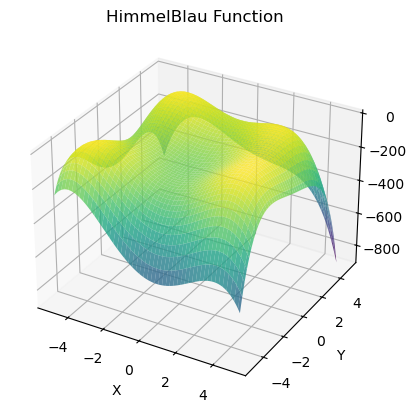

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create the grid of input values
x_range = np.linspace(-5, 5, 100)
y_range = np.linspace(-5, 5, 100)
x_grid, y_grid = np.meshgrid(x_range, y_range)

# Evaluate function on grid
z_grid = branin(x_grid, y_grid)

# Create the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_grid, y_grid, z_grid, cmap='viridis', alpha=0.8)

# Customize the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('HimmelBlau Function')

# Show the plot
plt.show()

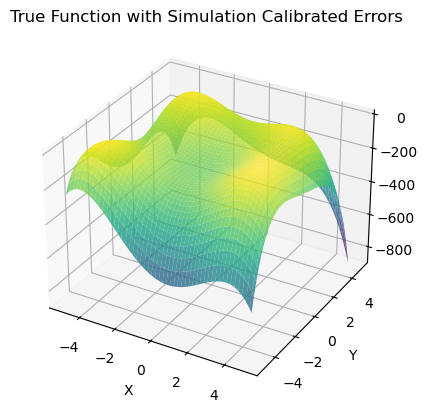

In [59]:
sim_z_grid = sim_eval(x_grid, y_grid, bo.x_opt[0], bo.x_opt[0])

# Create the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_grid, y_grid, sim_z_grid, cmap='viridis', alpha=0.8)

# Customize the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('True Function with Simulation Calibrated Errors')

# Show the plot
plt.show()

In [60]:
# Define the hyperparameter space
hyp_space  = [
    Integer(2, 10, name='num_layers'), # Num of layers in the network (depth)
    Integer(50, 200, name='num_units'), # Num of neurons in each hidden layer (width)
    Real(0.00001, 0.05, prior='log-uniform', name='learning_rate'), # Steps size at each iteration 
    Real(0.0, 0.5, name='dropout_rate'), # Probability of droping out a neuron
    Integer(20, 150, name='batch_size'), # Num of samples per batch
    Integer(50, 200, name='epochs') # Num of epochs (iterations over the entire dataset) during training
]

# Defining the Neural Network Model
def NN_model(num_layers, num_units, learning_rate, dropout_rate):
    inputs = Input(shape=(2,))
    x = Dense(num_units, activation='relu', kernel_regularizer='l2')(inputs)
    for _ in range(num_layers - 1):
        x = Dense(num_units, activation='relu', kernel_regularizer='l2')(x)
        x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='linear')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

# Function for MC Dropout predictions
def mc_dropout_predictions(model, X, num_samples=100):
    predictions = np.zeros((num_samples, X.shape[0]))
    for i in range(num_samples):
        predictions[i, :] = model(X, training=True).numpy().flatten()
    prediction_mean = predictions.mean(axis=0)
    prediction_std = predictions.std(axis=0)
    return prediction_mean, prediction_std


In [61]:
# Define the objective function to minimize
@use_named_args(hyp_space)
def objective(**params):
    num_layers = params['num_layers']
    num_units = params['num_units']
    learning_rate = params['learning_rate']
    dropout_rate = params['dropout_rate']
    batch_size = params['batch_size']
    epochs = params['epochs']

    model = NN_model(num_layers, num_units, learning_rate, dropout_rate)
    
    # Define K-fold cross-validation
    kfold = KFold(n_splits=3, shuffle=True, random_state=0)
    scores = []

    # Perform cross-validation
    for train_idx, val_idx in kfold.split(df[['x', 'y']]):
        X_train, X_val = df[['x', 'y']].iloc[train_idx], df[['x', 'y']].iloc[val_idx]
        y_train, y_val = df[['sim_z']].iloc[train_idx], df[['sim_z']].iloc[val_idx]

        # Standardize the features
        scaler_x = StandardScaler().fit(X_train)
        X_train_scaled = scaler_x.transform(X_train)
        X_val_scaled = scaler_x.transform(X_val)

        # Train the model
        model.fit(X_train_scaled, y_train, epochs=epochs, batch_size=batch_size, verbose=0, validation_data=(X_val_scaled, y_val))

        # Evaluate the model
        score = model.evaluate(X_val_scaled, y_val, verbose=0)
        scores.append(score)
    
    return np.mean(scores)

# Perform Bayesian optimization
result = gp_minimize(objective, hyp_space, n_calls=50, random_state=0, acq_func='EI')

# Output best hyperparameters from BayesOpt
print("Best hyperparameters:")
print("num_layers:", result.x[0])
print("num_units:", result.x[1])
print("learning_rate:", result.x[2])
print("dropout_rate:", result.x[3])
print("batch_size:", result.x[4])
print("epochs:", result.x[5])

# Train the model with the best hyperparameters on the entire dataset
best_model = NN_model(
    num_layers=result.x[0],
       num_units=result.x[1],
    learning_rate=result.x[2],
    dropout_rate=result.x[3]
)

# Standardize the initial dataset
scaler_x = StandardScaler().fit(df[['x', 'y']])
X_scaled = scaler_x.transform(df[['x', 'y']])

# Train the best model on the initial dataset
best_model.fit(X_scaled, df[['sim_z']], epochs=result.x[5], batch_size=result.x[4], verbose=1)

# Produce Uncertainty of Results
pred_mean, pred_std = mc_dropout_predictions(best_model, X_scaled)


Best hyperparameters:
num_layers: 4
num_units: 108
learning_rate: 0.021811457483628647
dropout_rate: 0.22497499495561385
batch_size: 100
epochs: 185
Epoch 1/185
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 19544.8105
Epoch 2/185
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 19012.4668
Epoch 3/185
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 16592.8457
Epoch 4/185
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 10652.1670
Epoch 5/185
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 7371.8486
Epoch 6/185
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 4247.7739
Epoch 7/185
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 4485.6787
Epoch 8/185
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 3968.1594
Epoch 9/185
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 2951.8333
Epoch 10/185
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 3129.3594
Epoch 11/185
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 2308.8413
Epoch 12/185
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 2410.5159
Epoch 13/185
1/1 ━━━━━━━━━━━━━

          x         y           z         a        b       sim_z       diff
0 -0.865194  5.000000 -321.144970  3.885247 -3.02138 -317.023940  -4.121030
1 -0.545601  4.984408 -331.961782  3.885247 -3.02138 -330.287435  -1.674346
2  1.495971  3.134845  -50.445489  3.885247 -3.02138  -37.934695 -12.510794
3  2.156249  4.279574 -185.783641  3.885247 -3.02138 -159.952129 -25.831512
4  0.463964  1.299098 -113.446003  3.885247 -3.02138 -112.288719  -1.157284
5  0.153692  2.260290  -78.992971  3.885247 -3.02138  -78.856917  -0.136054
6  2.699922  2.075881   -2.660320  3.885247 -3.02138   37.786073 -40.446394
7 -1.739147  1.052470 -106.219622  3.885247 -3.02138  -89.378166 -16.841457
8  1.367009  3.819722 -108.438492  3.885247 -3.02138  -98.073557 -10.364935
9  0.555556  3.080808  -67.167869  3.885247 -3.02138  -65.490585  -1.677284


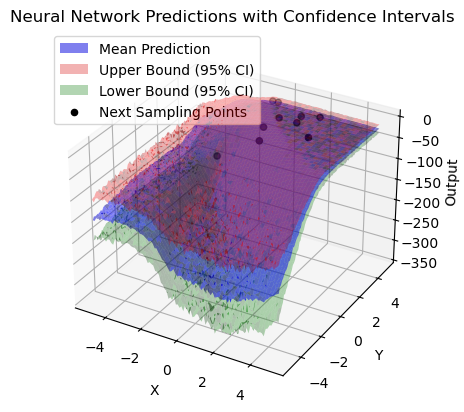

In [77]:
# Define the x1 and x2 range for the grid and bounds
x1_range = np.linspace(-5, 5, 100)
x2_range = np.linspace(-5, 5, 100)
bounds = np.array([[-5, 5], [-5, 5]])  # Bounds for x1 and x2

# Create a meshgrid and combine into a single array
x1_grid, x2_grid = np.meshgrid(x1_range, x2_range)
x_grid = np.c_[x1_grid.ravel(), x2_grid.ravel()]

# Perform MC Dropout predictions on the entire grid
pred_mean, pred_std = mc_dropout_predictions(best_model, x_grid)

# Calculate the Upper Confidence Level (UCL)
ucl = pred_mean + 1.96 * pred_std

# Locate the global maximum of the UCL
max_index = np.argmax(ucl)
global_max_point = x_grid[max_index]

# Generate 9 additional points using Latin Hypercube Sampling (LHS) around the global maximum
num_new_points = 9
lhs_sampler = qmc.LatinHypercube(d=2)
lhs_sample = lhs_sampler.random(num_new_points)

# Scale LHS samples to a region around the global UCL maximum
scaling_factor = 0.5  # Factor to control sampling range
lhs_x1 = global_max_point[0] + scaling_factor * (x1_range.max() - x1_range.min()) * (lhs_sample[:, 0] - 0.5)
lhs_x2 = global_max_point[1] + scaling_factor * (x2_range.max() - x2_range.min()) * (lhs_sample[:, 1] - 0.5)

# Combine the LHS samples with the global maximum point
new_points = np.c_[lhs_x1, lhs_x2]
global_max_point = global_max_point.reshape(1, -1)  # Reshape to 2D for consistency
all_points = np.vstack([new_points, global_max_point])  # Combine new points with the global max point

# Clip the points to stay within the defined bounds
all_points = np.clip(all_points, bounds[:, 0], bounds[:, 1])

# Calculate UCL values for the newly sampled points
new_mean, new_std = mc_dropout_predictions(best_model, all_points)
new_ucl = new_mean + 1.96 * new_std  # Calculate the UCL for all sampled points

# Store new sampled points and their UCL values in a DataFrame
new_points = pd.DataFrame(all_points, columns=['x', 'y'])
new_points_df = new_points.copy()
new_points['ucl'] = new_ucl  # Track UCL values

# Add simulated responses for new points
new_points_df['z'] = branin(new_points_df['x'], new_points_df['y']) + ran_err(10, 0.05)
new_points_df["a"] = bo.x_opt[0]
new_points_df["b"] = bo.x_opt[1]
new_points_df["sim_z"] = sim_eval(new_points_df['x'], new_points_df['y'], result.x[0], result.x[1])
new_points_df["diff"] = new_points_df["z"] - new_points_df["sim_z"]

print(new_points_df)

# Add new points to original dataframe
# df = pd.concat([df, new_points_df], axis=0, ignore_index=True)

# Produce Meshgrid of results with C.I.
x1_grid, x2_grid = np.meshgrid(x1_range, x2_range)
x_grid = np.c_[x1_grid.ravel(), x2_grid.ravel()]

x_grid_scaled = scaler_x.transform(x_grid)

# Perform MC Dropout predictions for entire meshgrid
pred_mean, pred_std = mc_dropout_predictions(best_model, x_grid_scaled)

# Reshape predictions back to grid shape
pred_mean_grid = pred_mean.reshape(x1_grid.shape)
pred_upper_grid = (pred_mean + (1.96 * pred_std)).reshape(x1_grid.shape)
pred_lower_grid = (pred_mean - (1.96 * pred_std)).reshape(x1_grid.shape)

# Plotting the predictions with confidence intervals and next sampling points
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the mean prediction surface
mean_surface = ax.plot_surface(x1_grid, x2_grid, pred_mean_grid, color='blue', alpha=0.5, label='Mean Prediction')

# Plot the upper and lower confidence intervals
upper_surface = ax.plot_surface(x1_grid, x2_grid, pred_upper_grid, color='red', alpha=0.3, label='Upper Bound (95% CI)')
lower_surface = ax.plot_surface(x1_grid, x2_grid, pred_lower_grid, color='green', alpha=0.3, label='Lower Bound (95% CI)')

# Plot the next sampling points from MH
ax.scatter(new_points['x'], new_points['y'], new_points['ucl'], color='black', marker='o', label='Next Sampling Points')

# Customize the plot
ax.set_title('Neural Network Predictions with Confidence Intervals')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Output')

# Legend
ax.legend(loc='upper left')

# Show the plot
plt.show()

In [ ]:
new_points_df

,x,y,z,a,b,sim_z,diff
0,2.114248,0.359706,-60.707537,3.885247,-3.02138,-48.677321,-12.030216
1,1.923766,1.150018,-51.854302,3.885247,-3.02138,-41.941416,-9.912886
2,-1.191904,0.424039,-147.980258,3.885247,-3.02138,-144.407555,-3.572704
3,-2.624454,-0.281033,-110.405885,3.885247,-3.02138,-92.466210,-17.939676
4,-4.184266,-1.922047,-77.181894,3.885247,-3.02138,-31.193228,-45.988666
5,-4.143754,-2.041261,-65.715346,3.885247,-3.02138,-20.682291,-45.033055
6,-3.698880,-1.904869,-50.576071,3.885247,-3.02138,-14.746129,-35.829942
7,-1.348023,-3.901432,-218.482460,3.885247,-3.02138,-213.796928,-4.685531
8,-3.704003,-3.764637,-13.070260,3.885247,-3.02138,22.824831,-35.895090
9,-4.201452,-1.273194,-120.692883,3.885247,-3.02138,-74.399494,-46.293389
